# Bayesian Randomized Benchmarking  Demo

## One-qubit Standard and Interleaved RB on Hardware

This is a bayesian pyMC3 implementation on top of frequentist interleaved RB from qiskit experiments

Based on this [WIP tutorial](https://github.com/Qiskit/qiskit-experiments/blob/main/docs/tutorials/randomized_benchmarking.ipynb) 
on july 31 2021

Note: the lenght range for standard and interleaved one-qubit RB was changed to np.arange(1, 2500, 250) because np.arange(1, 1000, 100) gave unreliable results with respect to the backend's reported EPG values, and this evenly for the least squared fit (LSF) and for the serial Monte Carlo process (SMC).

The hierarchical models are based on [equation 13 in this paper by Hincks et al.](https://arxiv.org/abs/1802.00401)

The models for interleaved RB use [equation 5 in this paper by Granade and al.](https://arxiv.org/abs/1404.5275)

In [1]:
import numpy as np
import copy
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library.randomized_benchmarking import RBUtils
import qiskit.circuit.library as circuits

# for retrieving gate calibration
from datetime import datetime
import qiskit.providers.aer.noise.device as dv

# import the bayesian packages
import pymc3 as pm
import arviz as az
import unif_bayesian_fitter as bf

In [2]:
simulation = False # make your choice here
if simulation:
    from qiskit.providers.aer import AerSimulator
    from qiskit.test.mock import FakeParis
    backend = AerSimulator.from_backend(FakeParis())
else:
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = provider.get_backend('ibmq_bogota') # type here hardware backend  

In [3]:
# for WIP
import importlib
importlib.reload(bf)

<module 'unif_bayesian_fitter' from 'C:\\Users\\decpi\\OneDrive\\Documents\\qiskit-tutorials-master\\tutorials\\noise\\unif_bayesian_fitter.py'>

# Running Standard 1-qubit RB

In [7]:
lengths = np.arange(1, 2225, 225)
num_samples = 10
seed = 1010
qubits = [4]

In [54]:
# last backend's recorded EPG before experiments
print(RBUtils.get_error_dict_from_backend(backend, qubits))

{((4,), 'id'): 0.00016003083311941815, ((4,), 'rz'): 0, ((4,), 'sx'): 0.00016003083311941815, ((4,), 'x'): 0.00016003083311941815}


In [9]:
# backend's recorded EPG after experiments
print(RBUtils.get_error_dict_from_backend(backend, qubits))

{((4,), 'id'): 0.00017715093107428107, ((4,), 'rz'): 0, ((4,), 'sx'): 0.00017715093107428107, ((4,), 'x'): 0.00017715093107428107}


In [13]:
# Correct reference for shift
# example of interpolated EPC_cal for hardware experiments
# EPC0 + (t_exp - tO) * (EPC1 - EPC0) / (t1 - t0)
# code here:
epc_calib = 0.0001600 + (18+25/60-7)*(0.0001772 - 0.0001600)/24
print('EPC calibration: {0:1.4e}'.format(epc_calib))

EPC calibration: 1.6818e-04


In [55]:
# Run an RB experiment on qubit 0
exp1 = StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend).block_for_results()
results1 = expdata1.analysis_results()

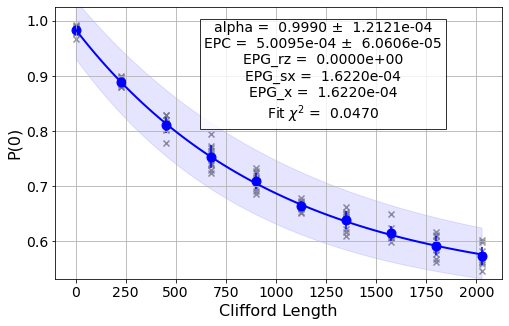

DbAnalysisResultV1
- name: @Parameters_RBAnalysis
- value: [0.47065117 0.99899809 0.51367658] ± [0.02563785 0.00012121 0.02729961]
- χ²: 0.0470228022709423
- extra: <3 items>
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9989980934925257 ± 0.00012121228706325197
- χ²: 0.0470228022709423
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0005009532537371686 ± 6.0606143531625986e-05
- χ²: 0.0470228022709423
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: EPG_rz
- value: 0.0
- χ²: 0.0470228022709423
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: EPG_sx
- value: 0.00016219684955182413
- χ²: 0.0470228022709423
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: EPG_x
- value: 0.00016219684955182413
- χ²: 0.0470228022709423
- device_components: ['Q4']
- verified: False


In [56]:
# View result data
display(expdata1.figure(0))
for result in results1:
    print(result)

In [57]:
popt = expdata1.analysis_results()[0].value.value
pcov = expdata1.analysis_results()[0].extra['covariance_mat']
epc_est_fm = expdata1.analysis_results()[2].value.value
epc_est_fm_err = expdata1.analysis_results()[2].value.stderr

EPG_dic = {}
for i in range(3,6):
    EPG_key = expdata1.analysis_results()[i].name
    EPG_dic[EPG_key] = expdata1.analysis_results()[i].value.value 

In [58]:
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
interleaved_gate =''

In [59]:
# get count data
Y = bf.get_GSP_counts(expdata1._data, len(lengths),range(num_samples))
expdata1._data[1]
experiment_type = expdata1._data[0]['metadata']['experiment_type']
physical_qubits = expdata1._data[0]['metadata']['physical_qubits']
shots = expdata1._data[0]['shots']

### Pooled model

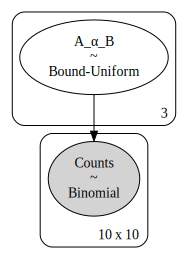

In [60]:
#build model
pooled_model = bf.build_bayesian_model(model_type="pooled",Y=Y,
                                       shots=shots,m_gates=lengths,
                                       popt = popt,
                                       pcov = pcov)
                                           
pm.model_to_graphviz(pooled_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A_α_B]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 139 seconds.
The number of effective samples is smaller than 25% for some parameters.


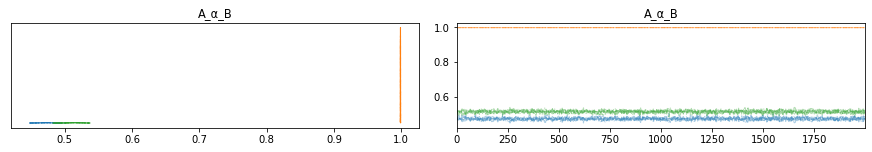

In [61]:
trace_p = bf.get_trace(pooled_model, target_accept = 0.95)

              mean        sd    hdi_3%   hdi_97%
A_α_B[0]  0.471608  0.007780  0.457604  0.486432
A_α_B[1]  0.999005  0.000034  0.998946  0.999071
A_α_B[2]  0.512535  0.007932  0.498285  0.527890 

Model:    Frequentist        Bayesian
_______________________________________
EPC         5.010e-04        4.975e-04 
± sigma    ± 6.061e-05      ± 1.700e-05 
EPG EPG_rz  0.000e+00        0.000e+00
EPG EPG_sx  1.622e-04        1.611e-04
EPG EPG_x   1.622e-04        1.611e-04


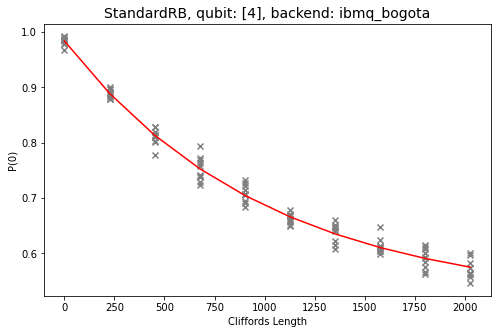

In [62]:
bf.RB_bayesian_results(pooled_model, trace_p, lengths,
                       epc_est_fm,
                       epc_est_fm_err,
                       experiment_type,
                       scale,                       
                       num_samples, Y, shots, physical_qubits, interleaved_gate, backend,
                       EPG_dic = EPG_dic,
                       routine = 'build_bayesian_model')

### Hierarchical model

model: [equation 13 in this paper](https://arxiv.org/abs/1802.00401)

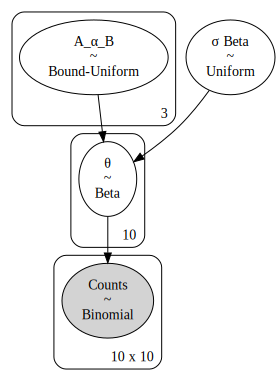

In [63]:
#build model
hierarchical_model = bf.build_bayesian_model(model_type="h_sigma",Y=Y,
                                           shots=shots,m_gates=lengths,
                                           popt = popt,
                                           pcov = pcov,
                                           sigma_theta=0.001,sigma_theta_l=0.0005,sigma_theta_u=0.0015)
pm.model_to_graphviz(hierarchical_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ Beta, A_α_B]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 989 seconds.
The number of effective samples is smaller than 25% for some parameters.


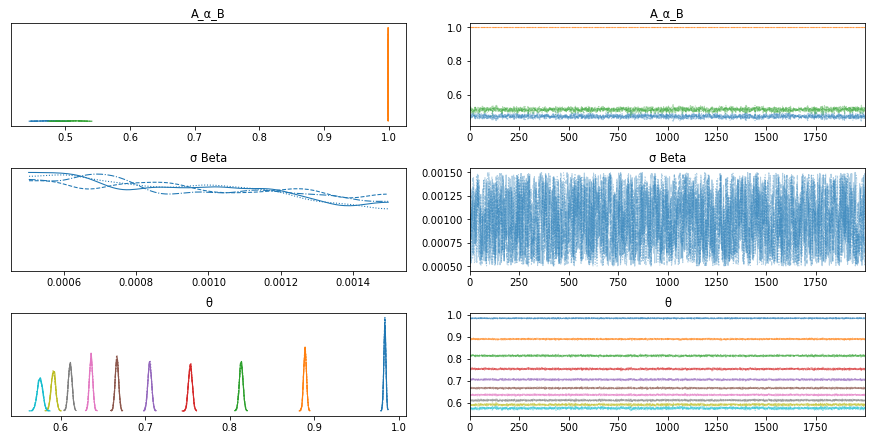

In [64]:
trace_h = bf.get_trace(hierarchical_model, target_accept = 0.99)

              mean        sd    hdi_3%   hdi_97%
A_α_B[0]  0.471812  0.008376  0.456138  0.487591
A_α_B[1]  0.999007  0.000037  0.998937  0.999076
A_α_B[2]  0.512226  0.008609  0.495883  0.528011
σ Beta    0.000972  0.000286  0.000500  0.001428
θ[0]      0.983662  0.001241  0.981350  0.985999
θ[1]      0.889197  0.001722  0.886147  0.892566
θ[2]      0.813601  0.002200  0.809634  0.817885
θ[3]      0.753429  0.002305  0.748928  0.757527
θ[4]      0.705363  0.002196  0.701293  0.709526
θ[5]      0.666472  0.002014  0.662499  0.670126
θ[6]      0.635878  0.001991  0.632246  0.639725
θ[7]      0.611185  0.002226  0.606846  0.615260
θ[8]      0.591314  0.002680  0.586321  0.596330
θ[9]      0.575394  0.003243  0.569340  0.581458 

Model:    Frequentist        Bayesian
_______________________________________
EPC         5.010e-04        4.965e-04 
± sigma    ± 6.061e-05      ± 1.850e-05 
EPG EPG_rz  0.000e+00        0.000e+00
EPG EPG_sx  1.622e-04        1.608e-04
EPG EPG_x   1.622e-04     

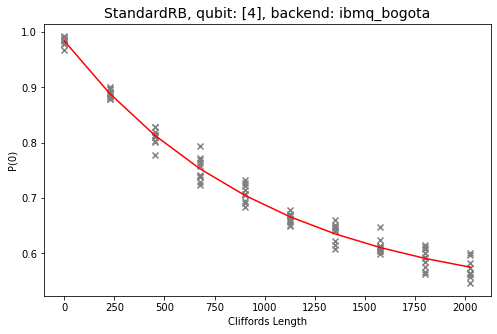

In [65]:
bf.RB_bayesian_results(hierarchical_model, trace_h, lengths,
                       epc_est_fm, epc_est_fm_err, experiment_type, scale,                       
                       num_samples, Y, shots, physical_qubits, interleaved_gate, backend,
                       EPG_dic = EPG_dic, routine = 'build_bayesian_model')

# Running 1-qubit Interleaved RB

Note: from here "EPC" refers to the error on the interleaved gate 

In [36]:
# describe RB experiment
interleaved_gate = "x"
qubits = [4]
interleaved_circuit = circuits.XGate()

lengths = np.arange(1, 2250, 225)
num_samples = 10
seed = 1010

### Least Squares Fit

In [37]:
# Run an interleaved RB experiment

int_exp1 = InterleavedRB(interleaved_circuit, qubits,
                            lengths, num_samples=num_samples, seed=seed)

# Run
int_expdata1 = int_exp1.run(backend).block_for_results()
int_results1 = int_expdata1.analysis_results()

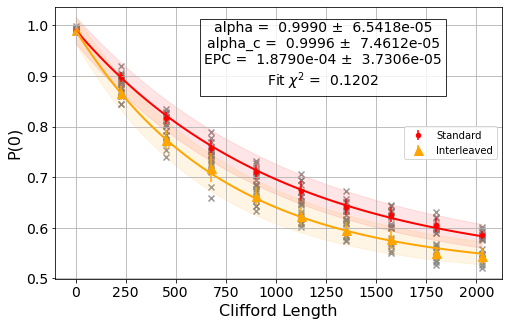

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.47204818 0.99901929 0.99962421 0.51882394] ± [1.29616871e-02 6.54184139e-05 7.46118224e-05 1.30416036e-02]
- χ²: 0.12022489317249728
- extra: <3 items>
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.9990192907805201 ± 6.541841394060566e-05
- χ²: 0.12022489317249728
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.9996242057777572 ± 7.461182241811701e-05
- χ²: 0.12022489317249728
- device_components: ['Q4']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.0001878971111213823 ± 3.730591120905851e-05
- χ²: 0.12022489317249728
- extra: <2 items>
- device_components: ['Q4']
- verified: False


In [38]:
# View result data
display(int_expdata1.figure(0))
for result in int_results1:
    print(result)

   ### prepare for SMC

In [39]:
popt = int_expdata1.analysis_results()[0].value.value
pcov = int_expdata1.analysis_results()[0].extra['covariance_mat']
popt[2] = popt[1]/popt[2] # replace alpha_C by p_tilde
# WIP rigorously the covariance matrix could be modified too if used
epc_est_fm = int_expdata1.analysis_results()[3].value.value
epc_est_fm_err = int_expdata1.analysis_results()[3].value.stderr

In [11]:
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
interleaved_gate ='x'

In [41]:
# get count data
Y1 = bf.get_GSP_counts(int_expdata1._data, len(lengths),
                    range(0,2*num_samples-1,2))

Y2 = bf.get_GSP_counts(int_expdata1._data, len(lengths),
                    range(1,2*num_samples,2))
int_expdata1._data[1]
experiment_type = int_expdata1._data[0]['metadata']['experiment_type']
physical_qubits = int_expdata1._data[0]['metadata']['physical_qubits']
shots = int_expdata1._data[0]['shots']

###  Serial Monte Carlo, pooled model

model: [equation 6 in this paper](https://arxiv.org/abs/1404.5275) 

In [42]:
Y=np.vstack((Y1,Y2))
RvsI = np.vstack((np.ones_like(Y1),np.zeros_like(Y2)))
IvsR = np.vstack((np.zeros_like(Y1),np.ones_like(Y2)))

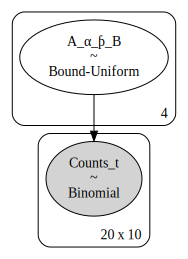

In [43]:
tilde1 =  bf.build_bayesian_model("tilde",Y=Y,shots=shots,
                                  m_gates=lengths,
                                  popt = popt,
                                  pcov = pcov,
                                  RvsI=RvsI,IvsR=IvsR)
pm.model_to_graphviz(tilde1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A_α_ƥ_B]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 163 seconds.
The number of effective samples is smaller than 25% for some parameters.


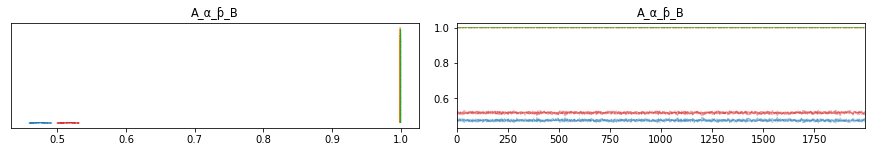

In [44]:
trace_t = bf.get_trace(tilde1)

#### NB: in the following results the reference must be corrected by interpolation for the shift

Becomes 1.680e-04 instead of 1.600e-04

                mean        sd    hdi_3%   hdi_97%
A_α_ƥ_B[0]  0.473897  0.004468  0.465083  0.481945
A_α_ƥ_B[1]  0.999018  0.000020  0.998979  0.999056
A_α_ƥ_B[2]  0.999651  0.000020  0.999612  0.999687
A_α_ƥ_B[3]  0.517103  0.004496  0.508651  0.525664 

Model:    Frequentist         Bayesian        Calibration
__________________________________________________________
EPC         1.879e-04        1.745e-04         1.600e-04
± sigma    ± 3.731e-05      ± 1.000e-05 


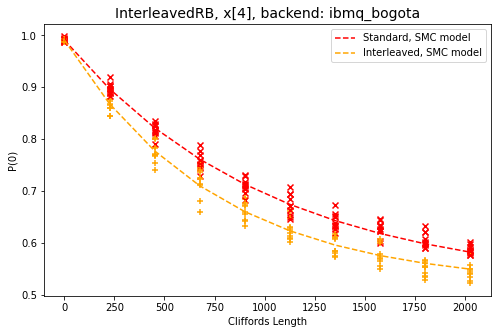

In [47]:
bf.RB_bayesian_results(tilde1, trace_t, lengths,
                   epc_est_fm, epc_est_fm_err, experiment_type, scale,                      
                   num_samples, Y, shots, physical_qubits, interleaved_gate, backend,
                   epc_calib = epc_calib, Y1 = Y1, Y2 = Y2,
                   routine = 'build_bayesian_model')

In [5]:
# Correct reference for shift
# example of interpolated EPC_cal for hardware experiments
# EPC0 + (t_exp - tO) * (EPC1 - EPC0) / (t1 - t0)
# code here:
epc_calib = 0.0001600 + (17+36/60-7)*(0.0001772 - 0.0001600)/24
print('EPC calibration: {0:.6f}'.format(epc_calib))

EPC calibration: 0.000168


###  Serial Monte Carlo, hierarchical model

model: [equation 6 in this paper](https://arxiv.org/abs/1404.5275) and [equation 13 in this paper](https://arxiv.org/abs/1802.00401)

In [48]:
import importlib
importlib.reload(bf)

<module 'unif_bayesian_fitter' from 'C:\\Users\\decpi\\OneDrive\\Documents\\qiskit-tutorials-master\\tutorials\\noise\\unif_bayesian_fitter.py'>

In [49]:
Y=np.hstack((Y1,Y2))
RvsI_h = np.ravel(np.vstack((np.ones_like(lengths),np.zeros_like(lengths))))
IvsR_h = np.ravel(np.vstack((np.zeros_like(lengths),np.ones_like(lengths))))

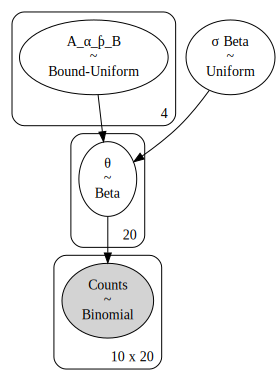

In [50]:
tilde2 =  bf.build_bayesian_model("h_tilde",Y=Y,shots=shots, m_gates=lengths,
                                 popt = popt,
                                 pcov = pcov,
                                 RvsI = RvsI_h, IvsR = IvsR_h,
                                 sigma_theta=0.001,sigma_theta_l=0.0005,sigma_theta_u=0.0015)  
                                            

pm.model_to_graphviz(tilde2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, σ Beta, A_α_ƥ_B]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 529 seconds.
The number of effective samples is smaller than 25% for some parameters.


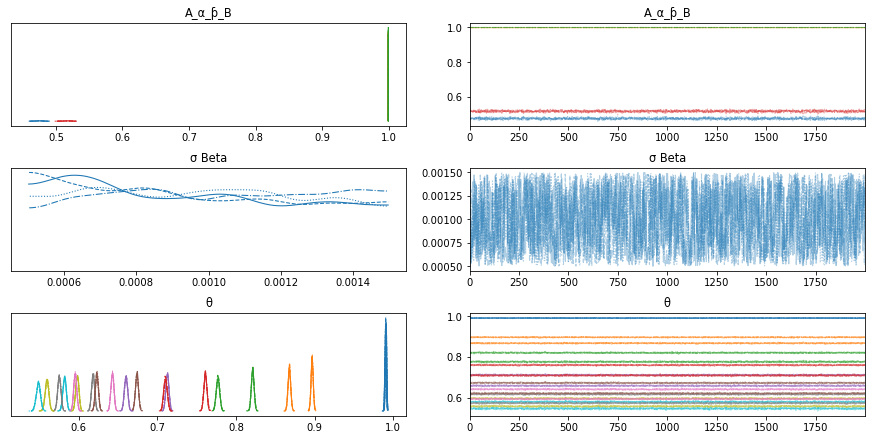

In [51]:
trace_t3 = bf.get_trace(tilde2, target_accept = .95)

#### NB: in the following results the reference must be corrected by interpolation for the shift

Becomes 1.680e-04 instead of 1.600e-04

                mean        sd    hdi_3%   hdi_97%
A_α_ƥ_B[0]  0.474214  0.004415  0.466217  0.483064
A_α_ƥ_B[1]  0.999021  0.000021  0.998982  0.999060
A_α_ƥ_B[2]  0.999652  0.000019  0.999615  0.999687
A_α_ƥ_B[3]  0.516649  0.004481  0.507685  0.524617
σ Beta      0.000983  0.000289  0.000503  0.001434
θ[0]        0.990769  0.000830  0.989206  0.992280
θ[1]        0.896722  0.001394  0.894020  0.899324
θ[2]        0.821214  0.001791  0.817940  0.824620
θ[3]        0.760991  0.001952  0.757296  0.764634
θ[4]        0.712698  0.001993  0.708892  0.716385
θ[5]        0.674013  0.001957  0.670195  0.677634
θ[6]        0.642847  0.001934  0.639307  0.646543
θ[7]        0.618310  0.001944  0.614742  0.621993
θ[8]        0.598235  0.002022  0.594415  0.601952
θ[9]        0.582032  0.002150  0.578054  0.586042
θ[10]       0.990124  0.000845  0.988443  0.991628
θ[11]       0.867821  0.001699  0.864580  0.870992
θ[12]       0.777056  0.002146  0.773168  0.781222
θ[13]       0.710421  0.002200 

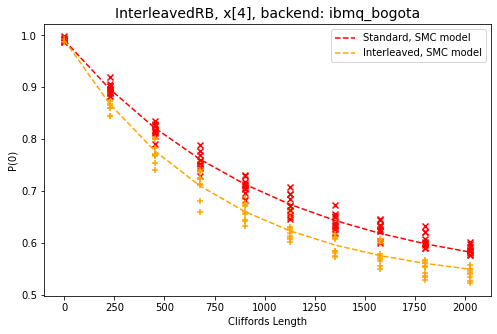

In [52]:
bf.RB_bayesian_results(tilde2, trace_t3, lengths,
                       epc_est_fm, epc_est_fm_err, experiment_type, scale,                      
                       num_samples, Y, shots, physical_qubits, interleaved_gate, backend,
                       epc_calib = epc_calib, Y1 = Y1, Y2 = Y2,
                       routine = 'build_bayesian_model')

In [5]:
# Correct reference for shift
# example of interpolated EPC_cal for hardware experiments
# EPC0 + (t_exp - tO) * (EPC1 - EPC0) / (t1 - t0)
# code here:
epc_calib = 0.0001600 + (17+36/60-7)*(0.0001772 - 0.0001600)/24
print('EPC calibration: {0:.6f}'.format(epc_calib))

EPC calibration: 0.000168
